## Netflix Stock Price Prediction

In [190]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

### Exploring the dataset 

In [2]:
# calling datasets
df = pd.read_csv("./NFLX.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [3]:
# dimensions
df.shape

(5044, 7)

In [4]:
# setting the date as index
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date").asfreq("b")
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000.0
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800.0
2002-05-27,NaN,NaN,NaN,NaN,NaN,NaN
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400.0
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800.0


In [5]:
# keeping the adjusted close and the volume for the prediction of stock price
df = df[["Adj Close", "Volume"]]
df.head()

,Adj Close,Volume
Date,,
2002-05-23,1.196429,104790000.0
2002-05-24,1.210000,11104800.0
2002-05-27,NaN,NaN
2002-05-28,1.157143,6609400.0
2002-05-29,1.103571,6757800.0


In [6]:
# checking for the null values 
df.isna().sum() # no null observations

Adj Close    183
Volume       183
dtype: int64

In [7]:
df = df.replace(method="bfill")

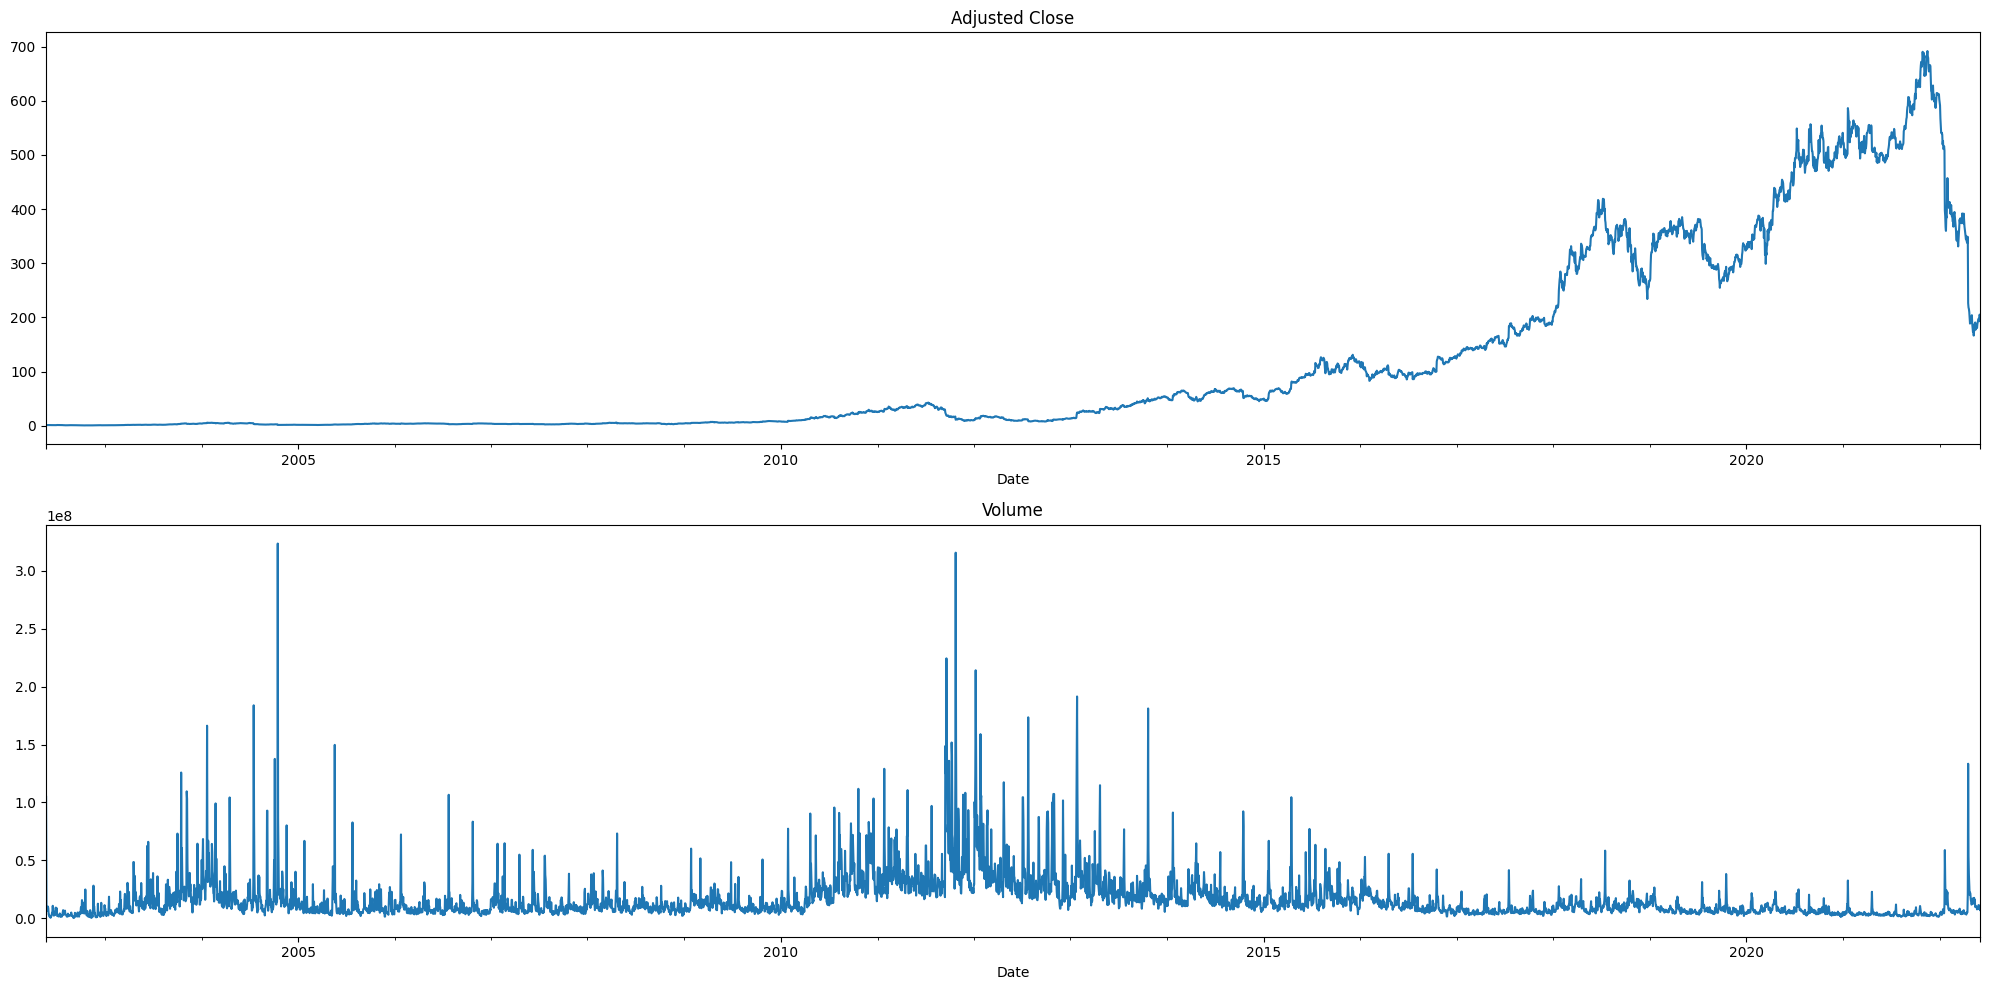

In [8]:
# plot of the data
fig, ax = plt.subplots(nrows=2)
df["Adj Close"].plot(figsize=(20,10), title="Adjusted Close", ax=ax[0])
df["Volume"].plot(figsize=(20,10), title="Volume", ax=ax[1])
plt.tight_layout()
plt.show() # stock price remained low level (close to zero) till may of 2010, after that it started to  increase and reached its boom at 2021
           # volume in the stock price market is negatively linearly related to stock price, but the relationship is not very strong  

In [9]:
# function for Dickey Fuller Test
def DickeyFuller(x):
    test = adfuller(x)
    return f'ADF Test\n----------\nTest Statistic:\t{test[0]}\np-value:\t{test[1]}\nH0:\t\tThe Series is not stationary\nDecision:\t{"Null Rejected" if test[1]<0.05 else "Null Accepted"}'

# checking the stationarity of the series
print(DickeyFuller(df["Adj Close"])) # not stationary

ADF Test
----------
Test Statistic:	-1.2699641298501416
p-value:	0.6427993198323034
H0:		The Series is not stationary
Decision:	Null Accepted


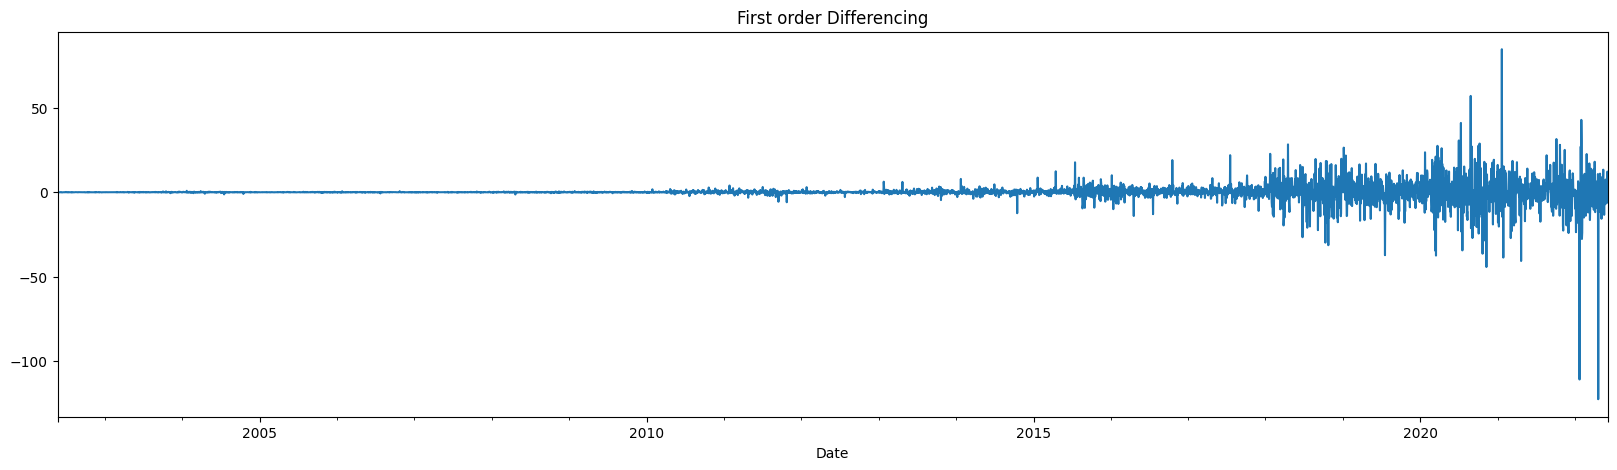

In [10]:
df["Adj Close"].diff(1).plot(figsize=(20,5), title="First order Differencing")
plt.show()

In [11]:
# checking the stationarity of the first order difference
print(DickeyFuller(df["Adj Close"].diff(1)[1:])) # stationary
                                                 # 1st order difference is Stationary means that the series definitely has underlying trend 

ADF Test
----------
Test Statistic:	-10.768635425340005
p-value:	2.4160802991501634e-19
H0:		The Series is not stationary
Decision:	Null Rejected


### Train Test Split

In [12]:
# creating a 80-20 split
size = int(len(df)*0.8)
tr_df = df.iloc[:size]
ts_df = df.iloc[size:]

### Model Fitting

In [13]:
# functions for acf and pcf plot
def acf_pacf(x, ylim=[-1,1,-1,1]):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    sgt.plot_acf(x, ax=ax[0], title="ACF", lags=40, zero=False)
    sgt.plot_pacf(x, ax=ax[1], title="PACF", lags=40, zero=False)
    ax[0].set_ylim(ylim[0], ylim[1])
    ax[1].set_ylim(ylim[2], ylim[3])
    plt.tight_layout()
    plt.suptitle(f"Series: {x.name}", size=20)
    plt.show()

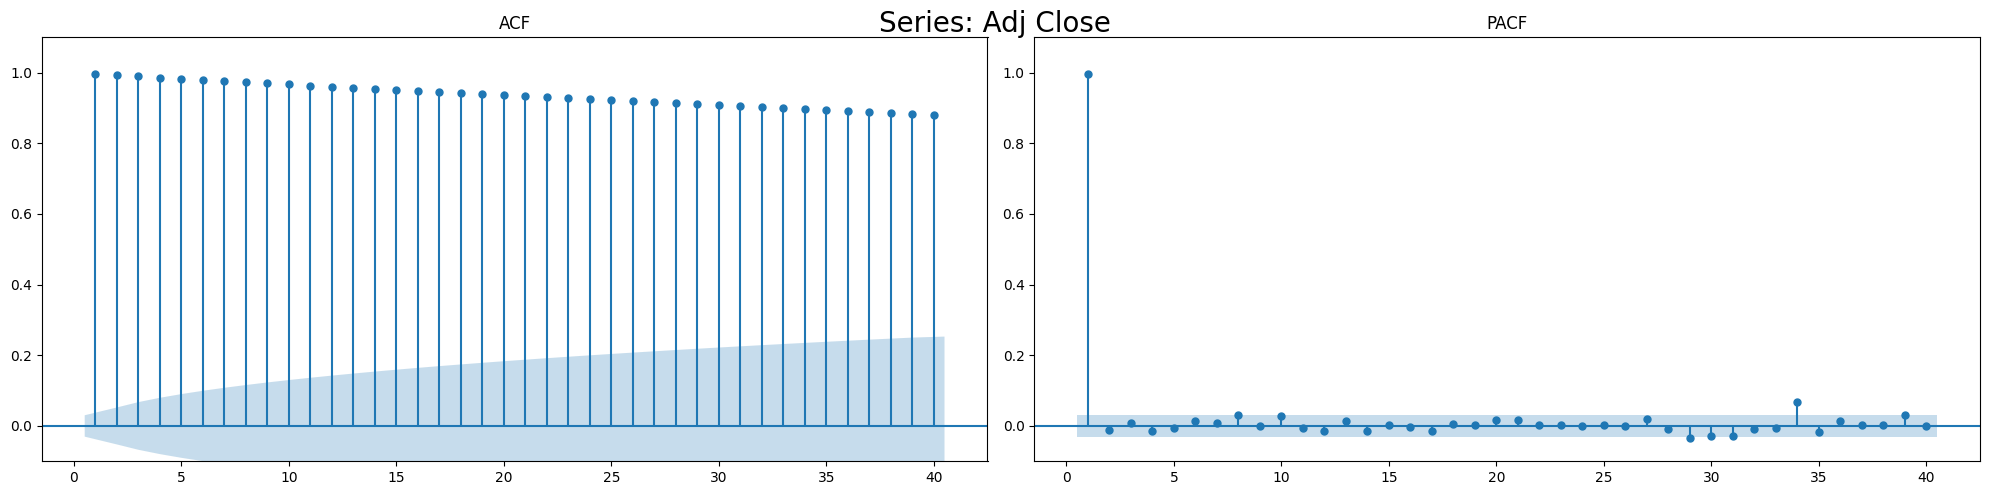

In [14]:
# ACF PACF plots of the series
acf_pacf(tr_df["Adj Close"], ylim=[-0.1, 1.1,-0.1,1.1])

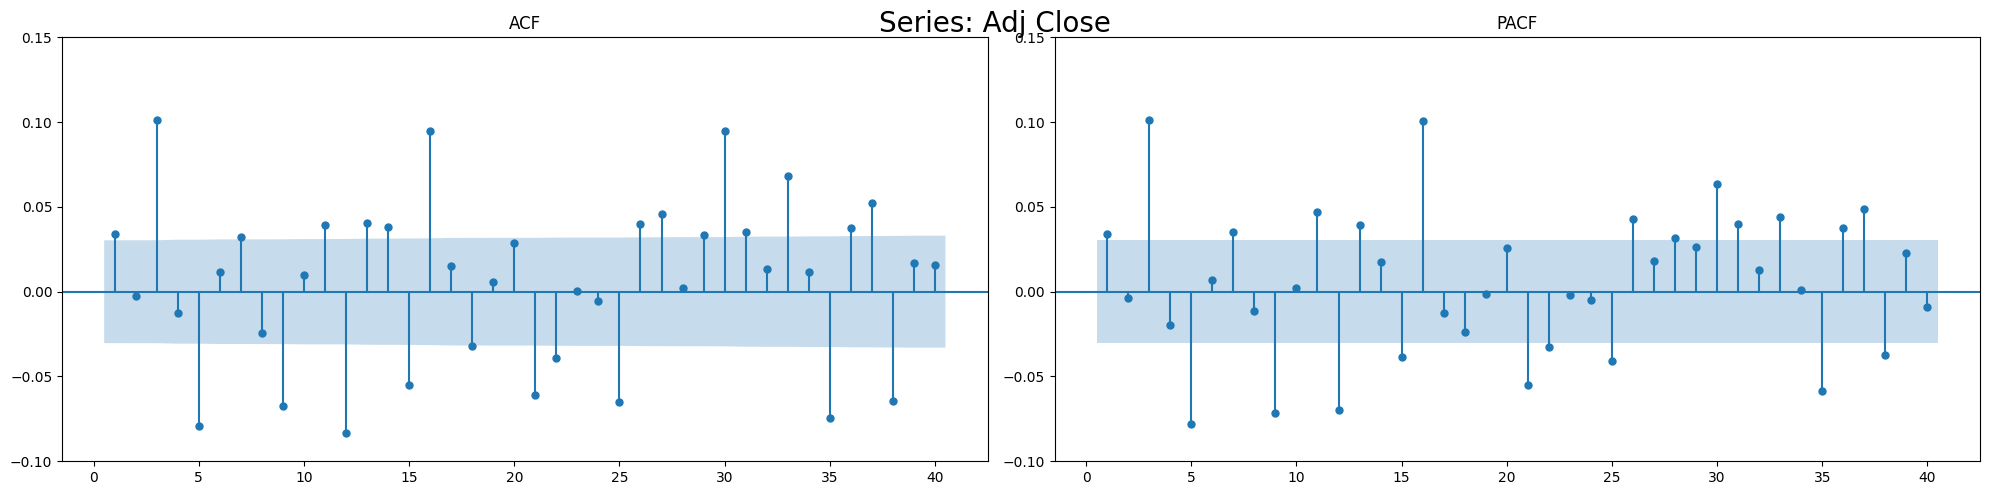

In [15]:
# ACF PACF plots of the series difference
acf_pacf(tr_df["Adj Close"].diff(1)[1:], ylim=[-0.1,0.15,-0.1,0.15]) # ACF have peaks at lag 3, 5, 6
                                                                     # PACF have peaks at lag 3, 5, 6

In [96]:
# fitted model 
model_sarima = ARIMA(tr_df["Adj Close"], order=(4,1,3), seasonal_order=(2,1,1,12))
sarima_fit = model_sarima.fit()
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Adj Close   No. Observations:                 4181
Model:             ARIMA(4, 1, 3)x(2, 1, [1], 12)   Log Likelihood               -8399.239
Date:                            Mon, 18 Dec 2023   AIC                          16820.478
Time:                                    21:06:52   BIC                          16890.165
Sample:                                05-23-2002   HQIC                         16845.129
                                     - 05-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2079      0.143      1.451      0.147      -0.073       0.489
ar.L2         -0.7694      0.029    -26.357      0.000      -0.827      -0.712
ar.L3          0.0772      0.112      0.688      0.491      -0.143       0.297
ar.L4         -0.0446      0.017     -2.559      0.010      -0.079      -0.010
ma.L1         -0.1644      0.143     -1.146      0.252      -0.445       0.117
ma.L2          0.7659      0.025     30.166      0.000       0.716       0.816
ma.L3          0.0442      0.115      0.384      0.701      -0.182       0.270
ar.S.L12      -0.1066      0.006    -17.686      0.000      -0.118      -0.095
ar.S.L24      -0.0274      0.008     -3.622      0.000      -0.042      -0.013
ma.S.L12      -0.9791      0.003   -366.276      0.000      -0.984      -0.974
sigma2         3.2619      0.018    184.297      0.000       3.227       3.297
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            357859.23
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):             739.59   Skew:                             2.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

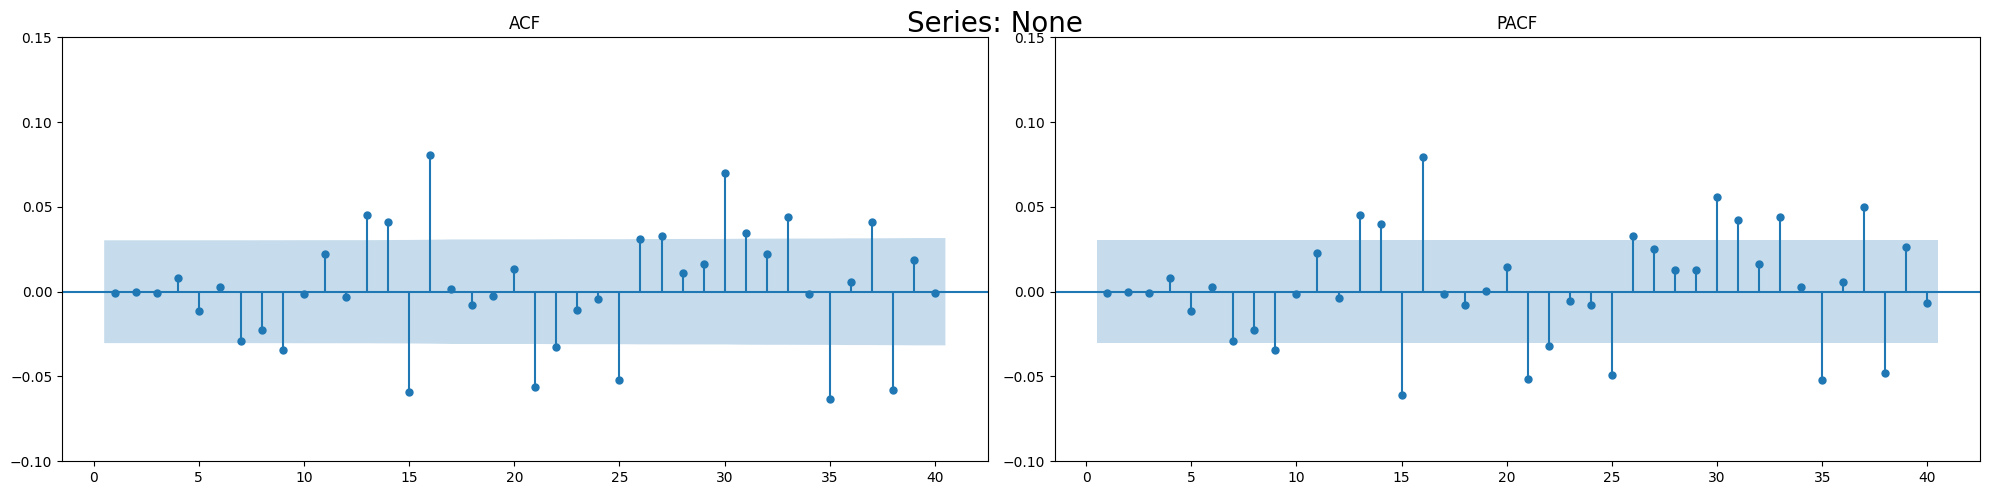

In [97]:
# ACF PACF plots of the SARIMA Residuals
acf_pacf(sarima_fit.resid, ylim=[-0.1,0.15,-0.1,0.15]) 

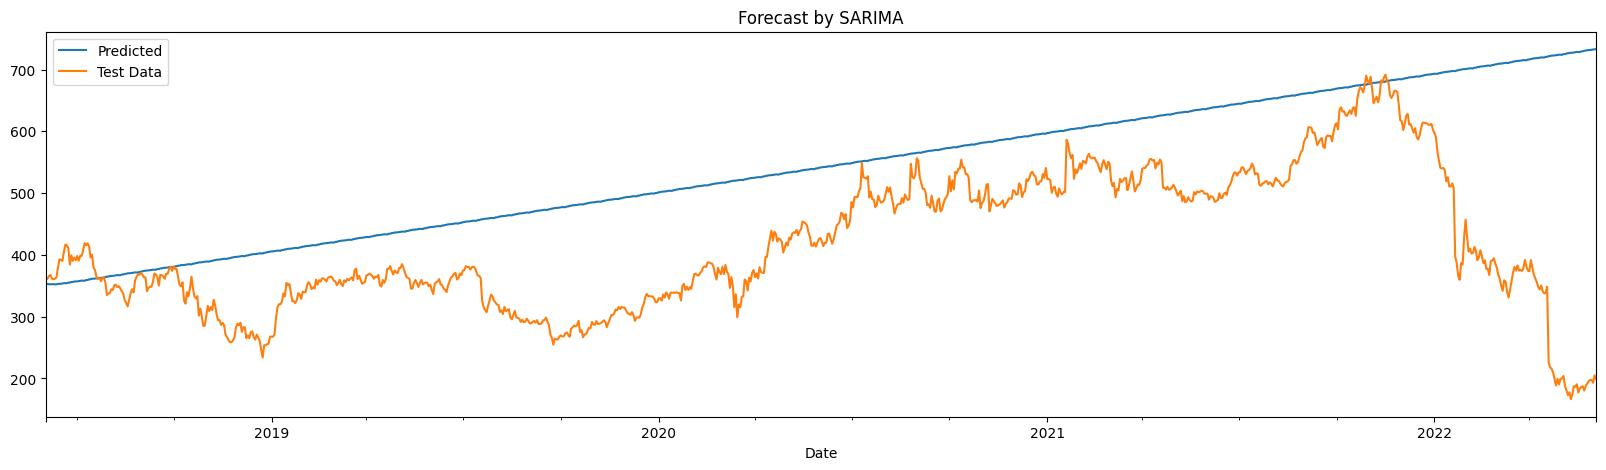

In [100]:
# prediction by SARIMA on the test dataset
sarima_pred = sarima_fit.get_forecast(steps=len(ts_df), exog=tr_df["Volume"]).predicted_mean
sarima_pred.plot(figsize=(20,5), label="Predicted")
ts_df["Adj Close"].plot(figsize=(20,5), label="Test Data")
plt.legend()
plt.title("Forecast by SARIMA")
plt.show()

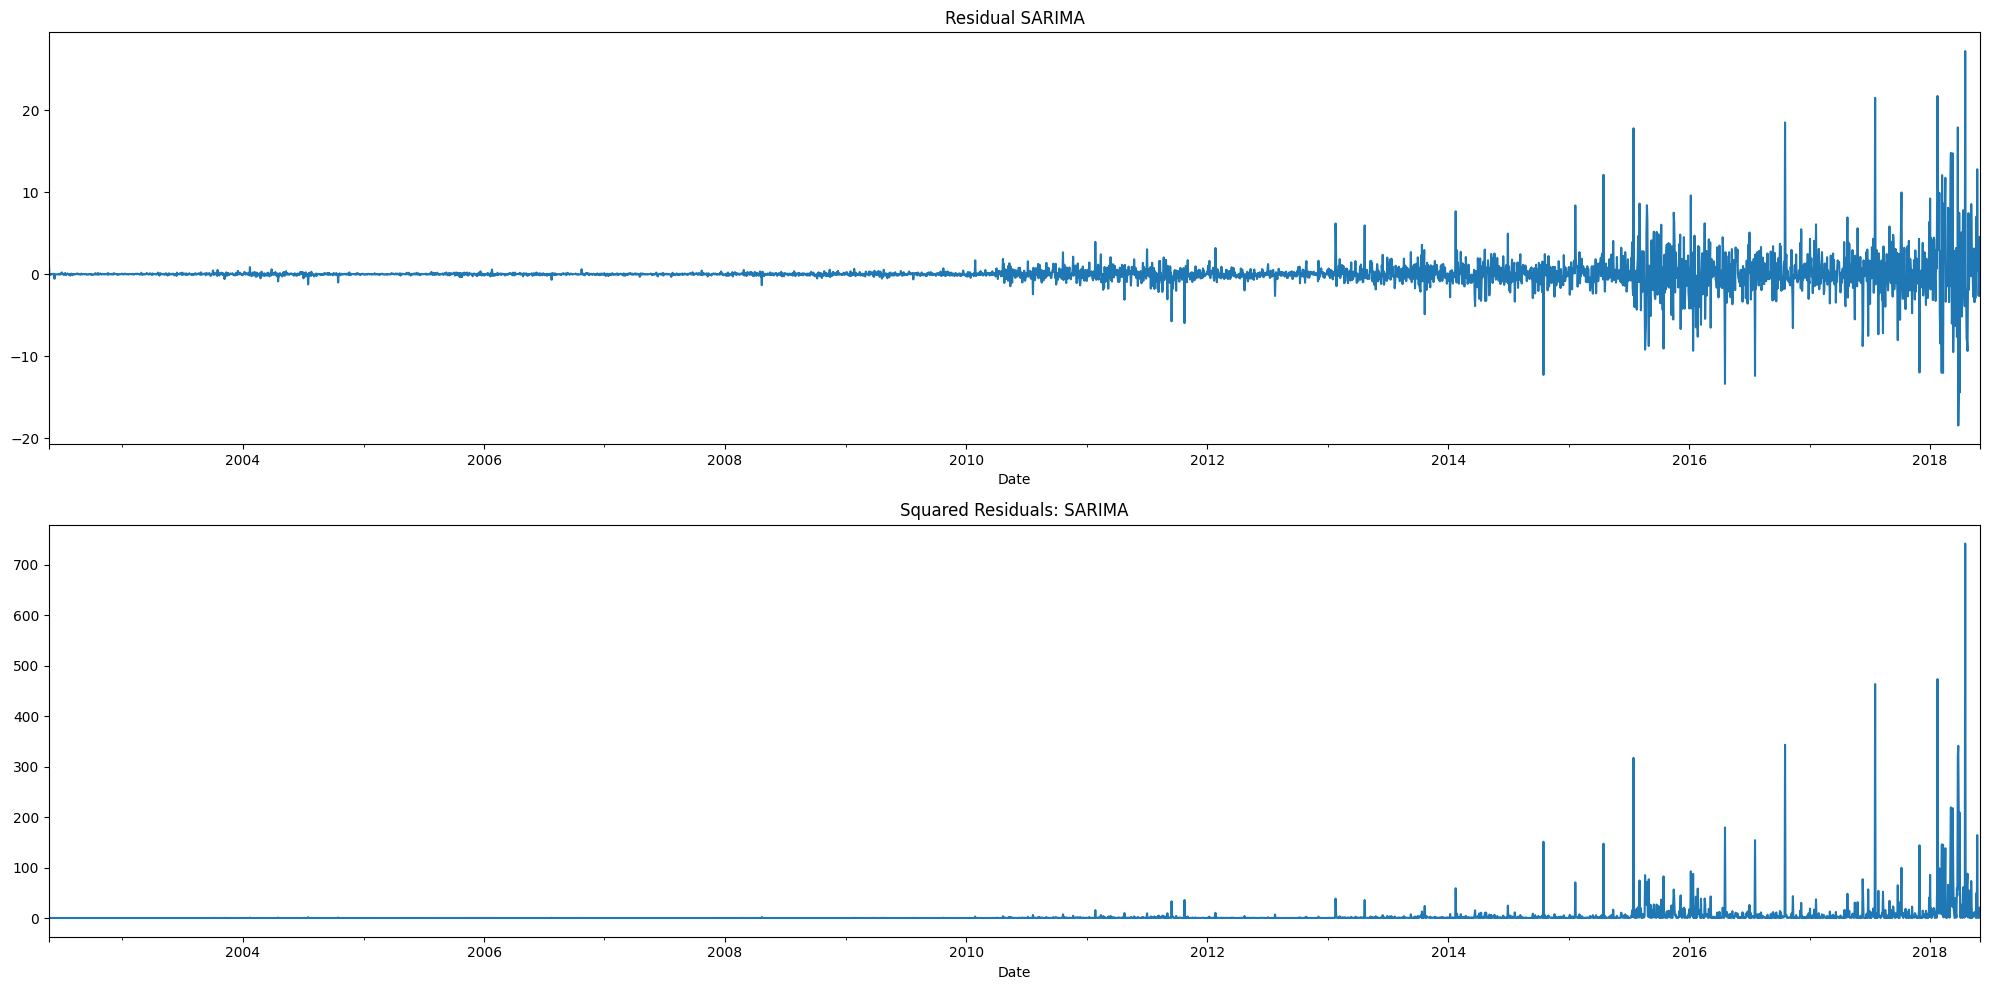

In [107]:
# residuals and squred residuals of SARIMA
fig, ax = plt.subplots(figsize=(20,10), nrows=2, ncols=1)
sarima_fit.resid.plot(title="Residual SARIMA", ax=ax[0])
(sarima_fit.resid**2).plot(title="Squared Residuals: SARIMA", ax=ax[1])
plt.tight_layout()
plt.show() # residuals seems stationary and spikes in the squared residuals proves the existence of the volatility factor in the residuals
           # need to model the volatility

In [113]:
# testing for the stationarity of the SARIMA residuals
print(DickeyFuller(sarima_fit.resid))

ADF Test
----------
Test Statistic:	-10.18274327573264
p-value:	6.628914136227976e-18
H0:		The Series is not stationary
Decision:	Null Rejected


In [169]:
# fitting GARCH model on the residuals 
resid_sarima = sarima_fit.resid
garch_model = arch_model(resid_sarima, vol="GARCH", mean="constant", p=1, q=3)
garch_fit = garch_model.fit(update_freq=0)
garch_fit.summary()

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 2857.9107358053234
            Iterations: 30
            Function evaluations: 245
            Gradient evaluations: 26


g:\All Docs\Sayan\Desktop\Netflix Stock Price Prediction\netflixenv\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2857.91
Distribution:                  Normal   AIC:                           5727.82
Method:            Maximum Likelihood   BIC:                           5765.85
                                        No. Observations:                 4181
Date:                Tue, Dec 19 2023   Df Residuals:                     4180
Time:                        00:12:31   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.2265e-03  2.464e-03      1.309      0.190 [-1.603e-03,8.056e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.2925e-04  1.162e-04      1.112      0.266 [-9.856e-05,3.571e-04]
alpha[1]       0.0832  2.047e-02      4.067  4.755e-05    [4.313e-02,  0.123]
beta[1]    6.9050e-07      0.126  5.466e-06      1.000      [ -0.248,  0.248]
beta[2]        0.2817      0.125      2.249  2.450e-02    [3.622e-02,  0.527]
beta[3]        0.6351      0.222      2.859  4.254e-03      [  0.200,  1.071]
=============================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Positive directional derivative for linesearch.
See convergence_flag.

"""

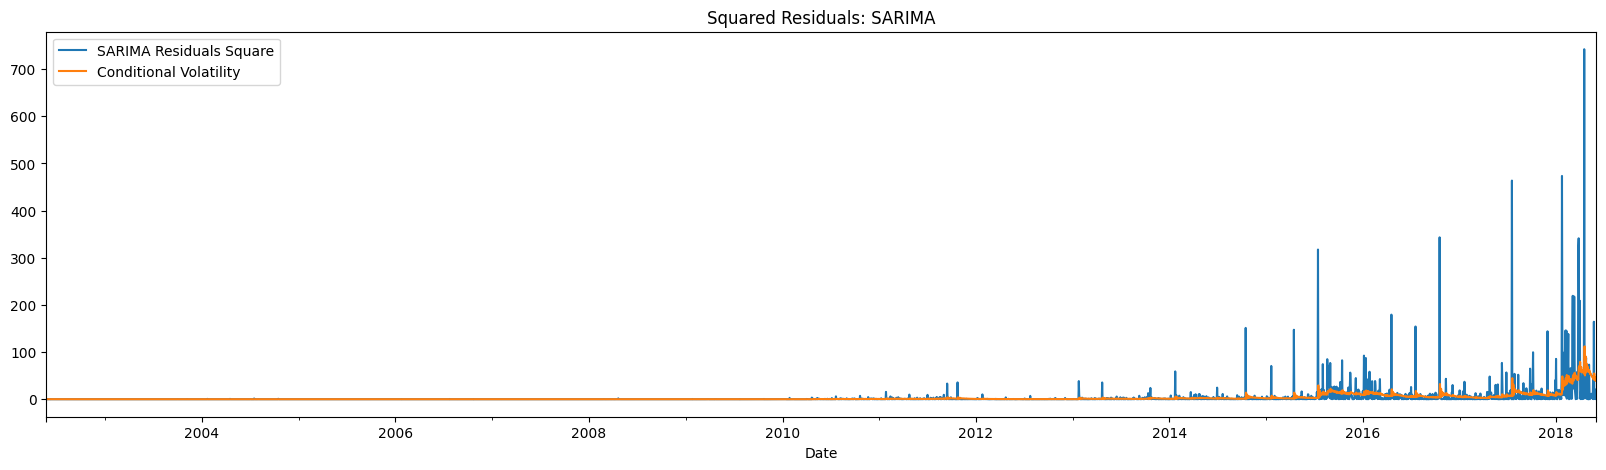

In [172]:
# fitted volatility
(sarima_fit.resid**2).plot(figsize=(20,5), title="Squared Residuals: SARIMA", label="SARIMA Residuals Square")
(garch_fit.conditional_volatility**2).plot(figsize=(20,5), label="Conditional Volatility")
plt.legend()
plt.show()

In [173]:
# prediction using the GARCH model
garch_forecast = garch_fit.forecast(horizon=len(ts_df))
mean_garch_forecast = garch_forecast.mean.iloc[-1,:]
var_garch_forecast = garch_forecast.variance.iloc[-1,:]

garch_pred = np.cumsum(np.random.normal(loc=mean_garch_forecast, scale=np.sqrt(var_garch_forecast)))

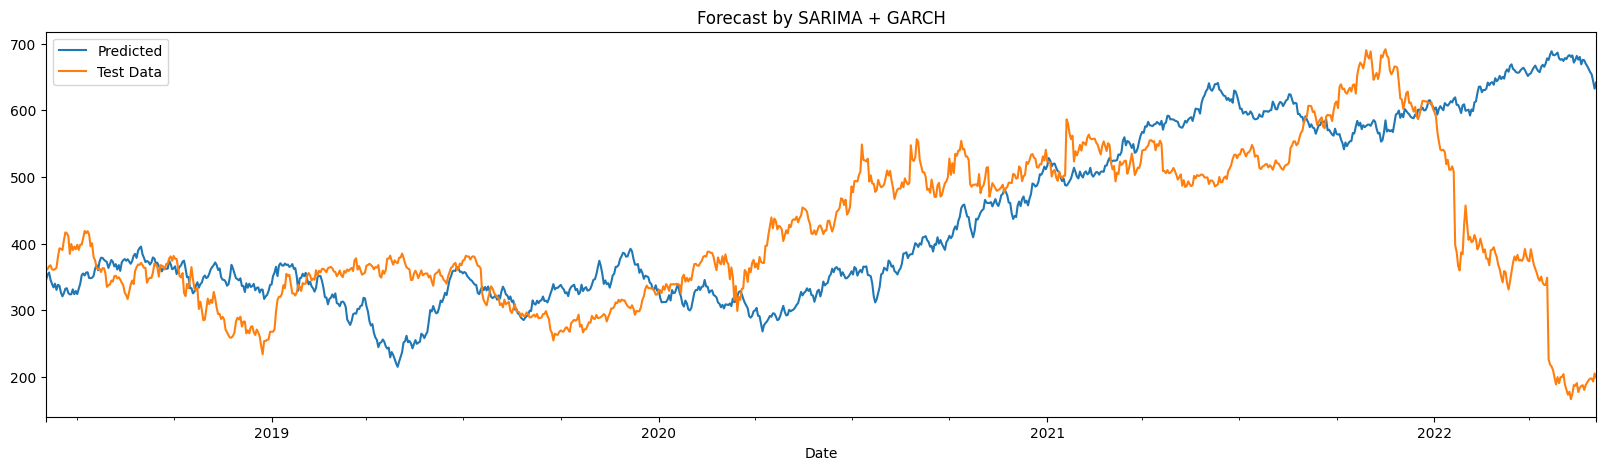

In [174]:
# GARCH prediction on the Test data
final_pred = sarima_pred + garch_pred
final_pred.plot(figsize=(20,5), label="Predicted")
ts_df["Adj Close"].plot(figsize=(20,5), label="Test Data")
plt.legend()
plt.title("Forecast by SARIMA + GARCH")
plt.show()

### Analysis of the Residuals

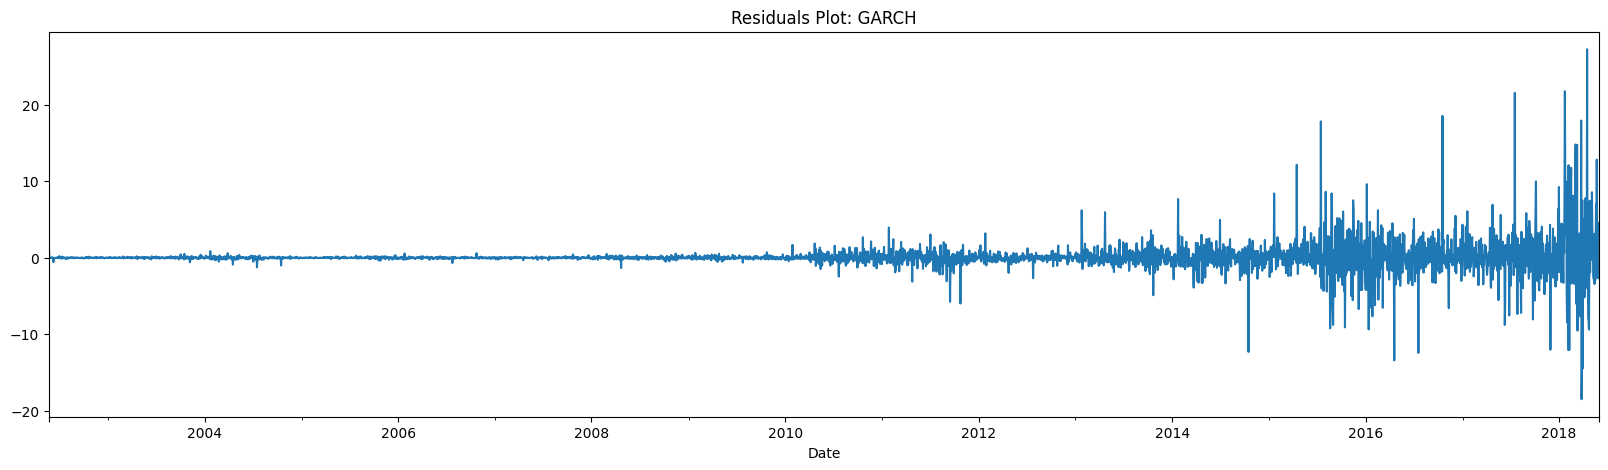

In [187]:
# plot of the GARCH Residuals
garch_fit.resid.plot(figsize=(20,5), title="Residuals Plot: GARCH")
plt.show() # heteroskedascticity has been reduced

In [189]:
# stationarity test of the residuals
print(DickeyFuller(garch_fit.resid)) # residuals are stationary

ADF Test
----------
Test Statistic:	-10.182743275732628
p-value:	6.628914136228407e-18
H0:		The Series is not stationary
Decision:	Null Rejected


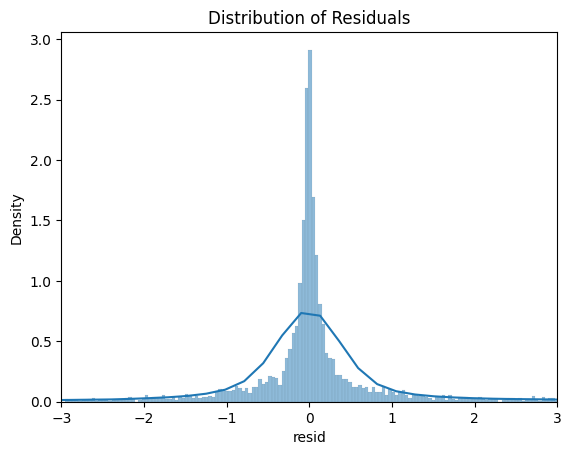

In [192]:
# histograme of the residuals
sns.histplot(garch_fit.resid, kde=True, stat="density")
plt.title("Distribution of Residuals")
plt.xlim((-3,3))
plt.show() # the residuals seems to be distributed with Laplace distribution

### Model Evaluation

In [193]:
# mean squared percentage error
print(f'''Mean Absolute Percentage Error(MAPE): {mean_absolute_percentage_error(ts_df["Adj Close"], final_pred)}''')

Mean Absolute Percentage Error(MAPE): 0.24981514959822113


### Final Fit

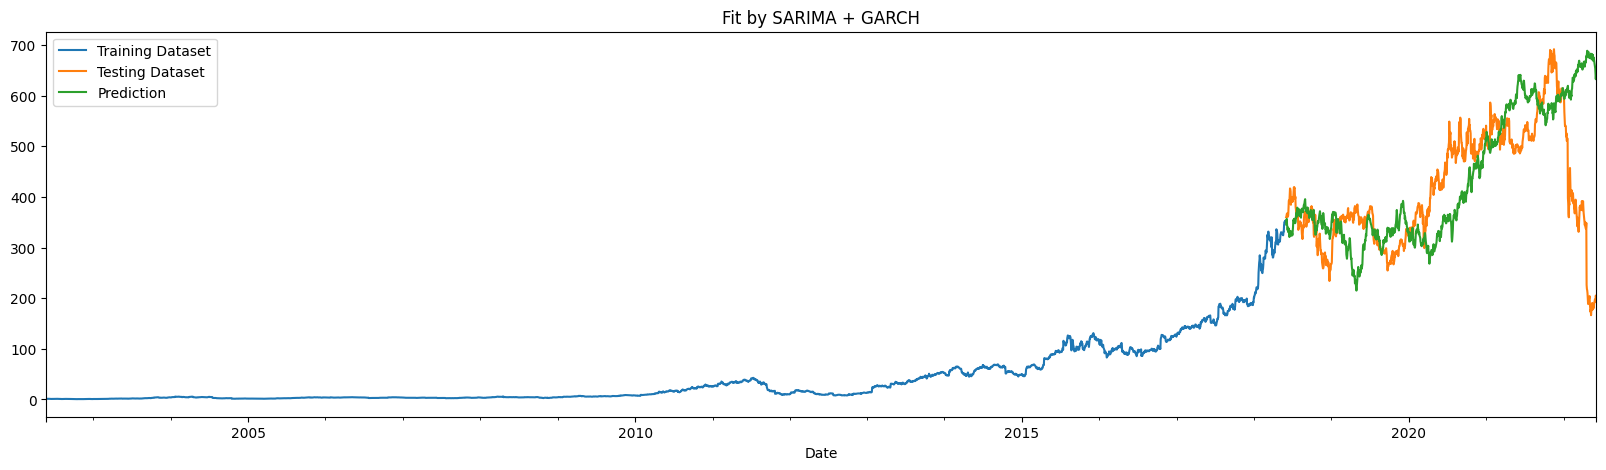

In [185]:
# the final fit 
tr_df["Adj Close"].plot(figsize=(20,5), label="Training Dataset")
ts_df["Adj Close"].plot(figsize=(20,5), label="Testing Dataset")
final_pred.plot(figsize=(20,5), label="Prediction")
plt.legend()
plt.title("Fit by SARIMA + GARCH")
plt.show()